In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import os

In [ ]:
  
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [ ]:
import pickle
with open('drive/My Drive/images.pkl','rb') as f:
  images=pickle.load(f)
with open('drive/My Drive/images2.pkl','rb') as f:
  images2=pickle.load(f)

In [ ]:
x_train=[]
for i in range(len(images)):
  x_train.append(images[i][0])
x_train=np.array(x_train)

In [ ]:
x_test=[]
for i in range(len(images2)):
  x_test.append(images2[i][0])
x_test=np.array(x_test)

In [ ]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

input_shape = (original_dim, )

In [ ]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var


In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 900)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          461312      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense[0][0]                      
____________________________________________________________________________________________

In [ ]:
# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder


In [ ]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 900)               461700    
Total params: 463,236
Trainable params: 463,236
Non-trainable params: 0
_________________________________________________________________


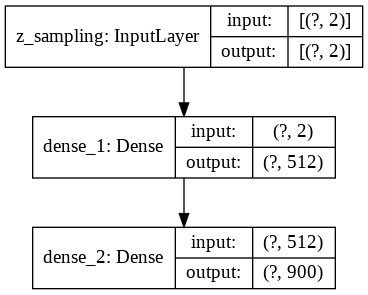

In [ ]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)


In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 900)]             0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 463364    
_________________________________________________________________
decoder (Functional)         (None, 900)               463236    
Total params: 926,600
Trainable params: 926,600
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [ ]:
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist_latent_dim_%s.h5' %latent_dim)
#vae.load_weights('vae_mlp_mnist_latent_dim_2.h5')

Epoch 1/50
41/41 [==============================] - 1s 31ms/step - loss: 24.8834 - val_loss: 5.6456
Epoch 2/50
41/41 [==============================] - 1s 31ms/step - loss: 4.6685 - val_loss: 3.9621
Epoch 3/50
41/41 [==============================] - 1s 28ms/step - loss: 3.5517 - val_loss: 3.1796
Epoch 4/50
41/41 [==============================] - 1s 28ms/step - loss: 3.1275 - val_loss: 2.9315
Epoch 5/50
41/41 [==============================] - 1s 28ms/step - loss: 2.7780 - val_loss: 2.4862
Epoch 6/50
41/41 [==============================] - 1s 31ms/step - loss: 2.0849 - val_loss: 1.6138
Epoch 7/50
41/41 [==============================] - 1s 28ms/step - loss: 1.5255 - val_loss: 1.4560
Epoch 8/50
41/41 [==============================] - 1s 28ms/step - loss: 1.4458 - val_loss: 1.4023
Epoch 9/50
41/41 [==============================] - 1s 28ms/step - loss: 1.4041 - val_loss: 1.3729
Epoch 10/50
41/41 [==============================] - 1s 28ms/step - loss: 1.3650 - val_loss: 1.3325
Epoch 11

In [ ]:
z_mean.shape

TensorShape([None, 2])

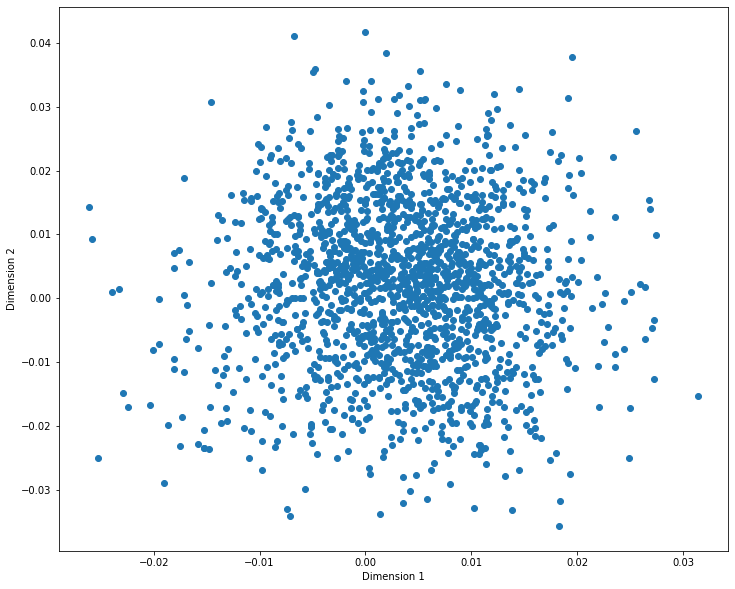

In [ ]:
model_name = 'vae_we'
filename = "vae_mean.png"
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig(filename)

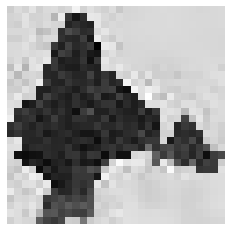

In [ ]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(img, cmap = 'gray_r')
plt.savefig('seven_original.png')

In [ ]:
encoder_input = np.expand_dims(x_test[0], axis = 0)

In [ ]:
encoder_input.shape, encoder.input_shape

((1, 900), (None, 900))

In [ ]:
mean, var, z = encoder.predict(encoder_input)

In [ ]:
decoded_output = decoder.predict(mean)

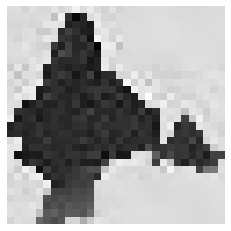

In [ ]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('seven_reproduced.png')

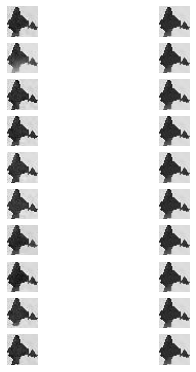

In [ ]:
plt.ioff()
plt.figure(figsize=(5, 20))
for i in range(10):
    plt.subplot(30, 2, 2*i+1)
    img = np.reshape(x_test[i], (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray_r')

    plt.subplot(30, 2, 2*i + 2)
    encoder_input = np.expand_dims(x_test[i], axis = 0)
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict(mean)
    img = np.reshape(x_test[0], (image_size, image_size))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('mn_reproduction.png')

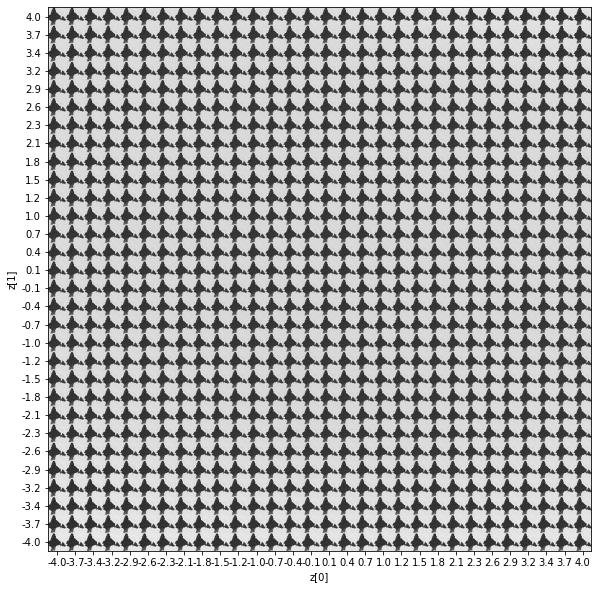

In [ ]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 30
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray_r')


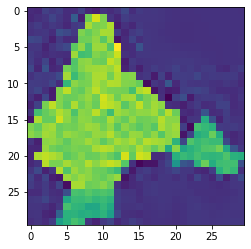

In [ ]:
plt.imshow(x_train[0].reshape((30,30)))